# Hosting Capacity for Centralized New Generation: Overvoltage Example

In this example, we calculate the hosting capacity for a new generation at a specific bus, considering the overvoltage metric. This example uses Python to control OpenDSS.

1. OpenDSS: <https://www.epri.com/pages/sa/opendss>
2. py-dss-interface: <https://pypi.org/project/py-dss-interface/>

In [2]:
# -*- coding: utf-8 -*-
# @Author  : Paulo Radatz
# @Email   : pradatz@epri.com

In [3]:
import py_dss_interface
import os
import pathlib
import numpy as np
from py_dss_tools import dss_tools

In [4]:
from FeederCondition import FeederCondition
from HCSteps import HCSteps
from HCSeetings import HCSettings

## Feeder Model

Hosting capacity analysis requires a feeder model. You can find the feeder used in this example at <https://github.com/rkerestes/IEEE1729DynamicsTF/tree/main/HCA>

In [5]:
dss_file = r"C:\PauloRadatz\GitHub\IEEEP1729-HCA\feeders\105bus\HCABase.dss"

In [6]:
dss = py_dss_interface.DSS()
dss_tools.update_dss(dss)
dss.text(f"compile [{dss_file}]")
dss.text("edit EnergyMeter.m2 enabled=no")

''

## Bus Selection

The bus selection is indicated below.

In [7]:
bus = "bus_1101"

## Load and Connected Generation Models

We set the load and connected (existing) generation models for the analysis. In this example, the load models maintain constant current at any voltage level. OpenDSS does not support a constant current model for connected generations, so they are defined as constant power. We could model these as a negative load and set them as constant current.

In [8]:
FeederCondition.set_load_model(dss)
FeederCondition.set_generator_model(dss)

## Feeder Condition | Hosting Capacity Impact Factors

This example considers three impact factors. The first is the feeder's loading level. The second is how regulators factor into the hosting capacity analysis. Lastly, we consider whether the connected generation is part of the analysis. Reference: <https://ieeexplore.ieee.org/document/10136862>

These impact factors are intended to modify the baseline power flow used in hosting capacity analysis.

In [9]:
hc_settings = HCSettings(load_mult=0.2, push_reg=1, capacitor=False, add_existing_ger=False, mult_existing_gen=1)

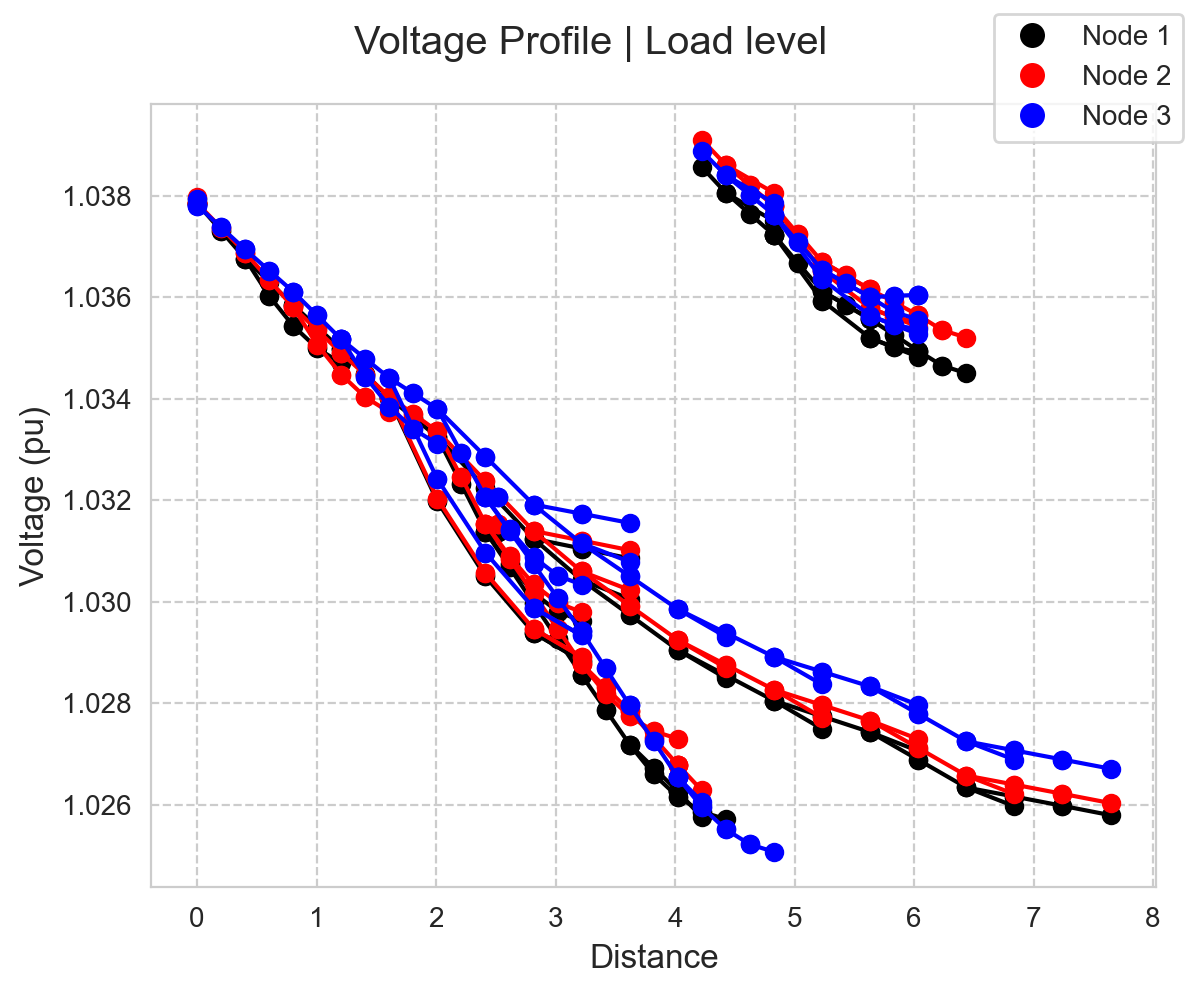

<Figure size 1000x600 with 0 Axes>

In [10]:
FeederCondition.set_capacitor_status(dss, capacitor=hc_settings.capacitor)
FeederCondition.set_load_level_condition(dss, load_mult=hc_settings.load_mult)
dss_tools.view.voltage_profile(title="Voltage Profile | Load level")

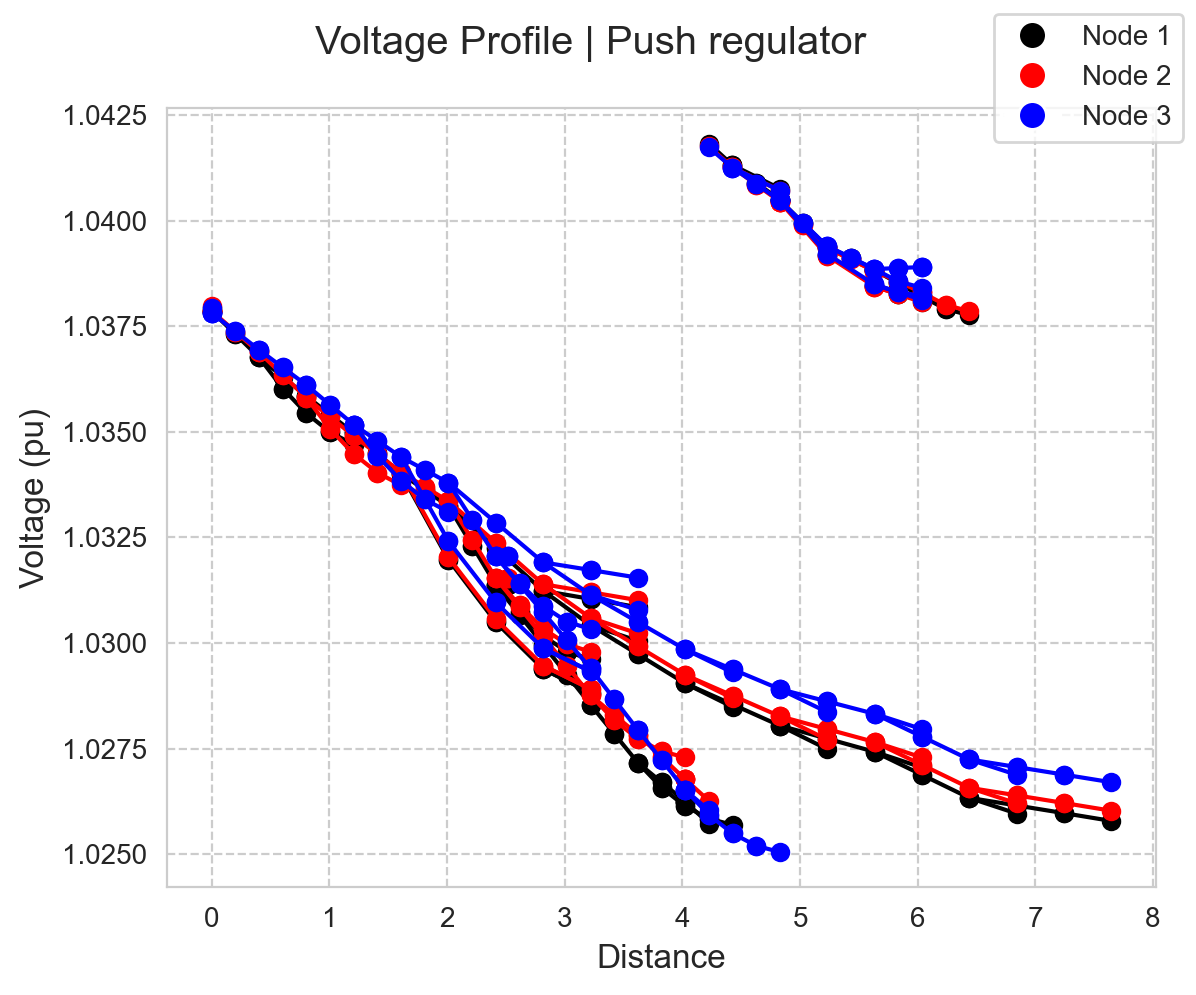

<Figure size 1000x600 with 0 Axes>

In [11]:
FeederCondition.push_regulators(dss, hc_settings.push_reg)
dss_tools.view.voltage_profile(title="Voltage Profile | Push regulator")

In [12]:
FeederCondition.consider_existing_gen(dss, hc_settings.add_existing_ger)

## Adding a New Generator to the Feeder Model

We add a generator model (which could be a negative load for a constant current model) to the feeder model. In this example, the generator is 3-phase.

In [13]:
dss.circuit.set_active_bus(bus)
kv = dss.bus.kv_base * np.sqrt(3)
gen_bus = {"gen": dss.bus.name}
gen_kv = {"gen": kv}
HCSteps.add_gen(dss, gen_bus, gen_kv)

## Hosting Capacity Iterative Process

The hosting capacity iterative process incrementally increases the new generator's size. It then performs a power flow check for voltage violation. The process ends if there's a voltage violation, a voltage across the feeder exceeds the overvoltage threshold of 1.05 pu, or if the generator size reaches the maximum analyzed size, in this case, 10 MW.

Thus, the hosting capacity corresponds to the generator size from the previous iteration before the violation.

In [14]:
i = 0
while i * HCSteps.step_kw < HCSteps.max_kw:
    i = i + 1
    i_kw = i * HCSteps.step_kw
    gen_kw = {"gen": i_kw}

    # Set Penetration Level
    HCSteps.increase_gen(dss, gen_kw)

    # Perform Power flow
    HCSteps.solve_powerflow(dss)

    # Violation?
    if HCSteps.check_overvoltage_violation(dss):
        hosting_capacity_value_kw = (i - 1) * HCSteps.step_kw
        # dss.dssinterface.datapath = f"{script_path}"
        # dss.text(f"save circuit dir=dss_circuit")
        break

In [15]:
print(f"Hosting Capacity = {hosting_capacity_value_kw / 1000} MW")

Hosting Capacity = 2.49 MW


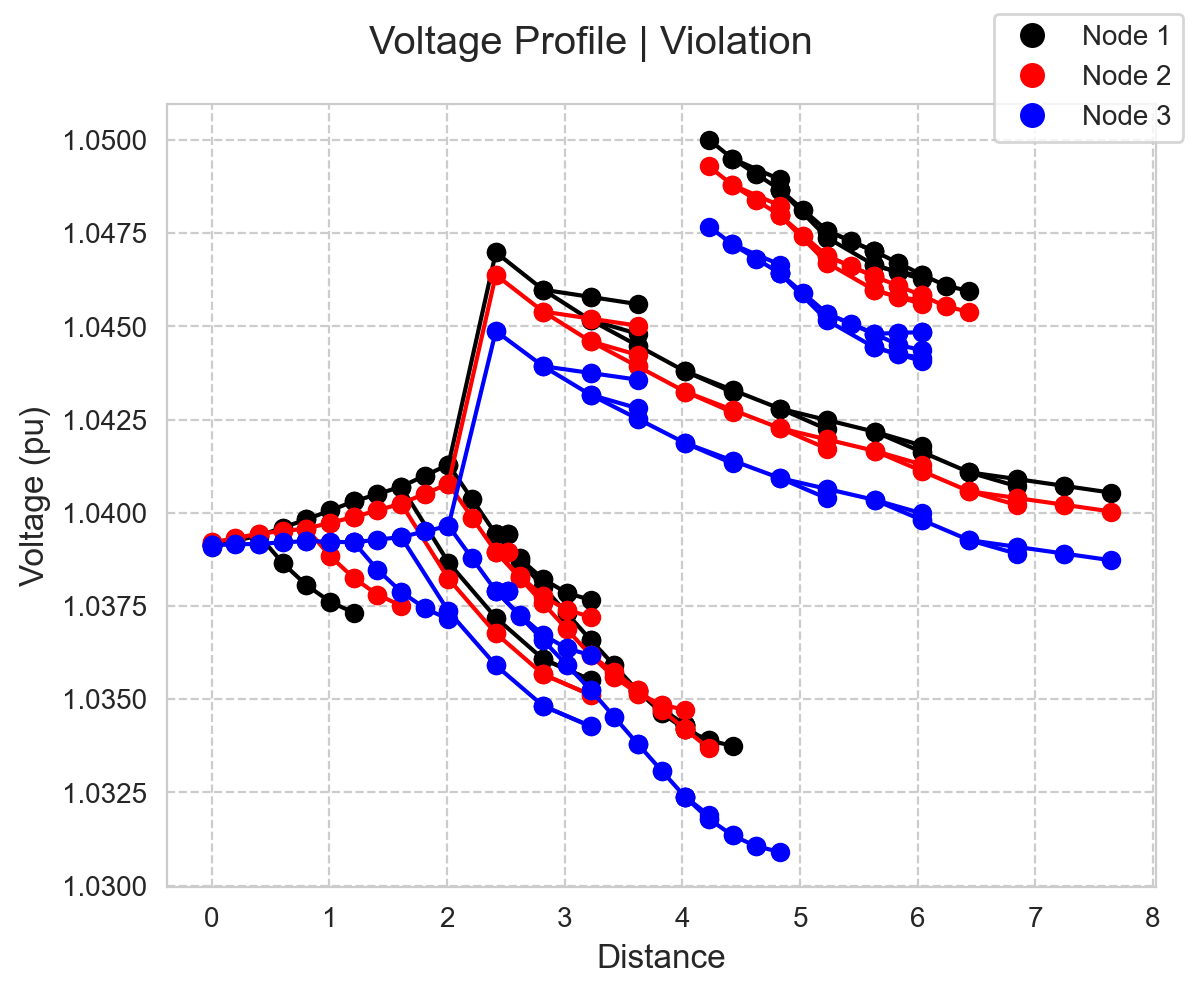

<Figure size 1000x600 with 0 Axes>

In [16]:
dss_tools.view.voltage_profile(title="Voltage Profile | Violation")

## Hosting Capacity Result

This example demonstrates that the hosting capacity result depends on various settings:

- Loading level
- Regulator consideration in the analysis
- Existing generation

More impact factors can be considered in the analysis, such as smart inverter functionalities for the new generation.

The model itself can also significantly impact the hosting capacity results. For instance, whether the lines are modeled as positive and negative sequences, which load and generation models are considered, etc.